# Project 4 

## Problem Statement

## Executive Summary

### Import libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

import pyreadr
import myfunctions as f
import io

%matplotlib inline

### Data Import

In [2]:
df_train = pd.read_csv('../datasets/train.csv')
df_test = pd.read_csv('../datasets/test.csv')
df_spray = pd.read_csv('../datasets/spray.csv')
df_weather = pd.read_csv('../datasets/weather.csv')

## Data Cleaning

### General Cleaning for all dataframes

In [3]:
df_train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [4]:
df_weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [5]:
df_spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [6]:
# Apply lower() to column names for all 3 dataframes
df_weather.columns = df_weather.columns.str.lower()
df_train.columns = df_train.columns.str.lower()
df_spray.columns = df_spray.columns.str.lower()

In [7]:
# Check datatypes
print('Train dataset')
print(df_train.dtypes)
print()
print('Weather dataset')
print(df_weather.dtypes)
print()
print('Spray dataset')
print(df_spray.dtypes)
print()

Train dataset
date                       object
address                    object
species                    object
block                       int64
street                     object
trap                       object
addressnumberandstreet     object
latitude                  float64
longitude                 float64
addressaccuracy             int64
nummosquitos                int64
wnvpresent                  int64
dtype: object

Weather dataset
station          int64
date            object
tmax             int64
tmin             int64
tavg            object
depart          object
dewpoint         int64
wetbulb         object
heat            object
cool            object
sunrise         object
sunset          object
codesum         object
depth           object
water1          object
snowfall        object
preciptotal     object
stnpressure     object
sealevel        object
resultspeed    float64
resultdir        int64
avgspeed        object
dtype: object

Spray dataset
date        

In [8]:
# Change Date datatype to datetime
df_train['date'] = pd.to_datetime(df_train['date'])
df_weather['date'] = pd.to_datetime(df_weather['date'])
df_spray['date'] = pd.to_datetime(df_spray['date'])

In [9]:
# Check datatypes
print('Train dataset')
print(df_train.dtypes)
print()
print('Weather dataset')
print(df_weather.dtypes)
print()
print('Spray dataset')
print(df_spray.dtypes)
print()

Train dataset
date                      datetime64[ns]
address                           object
species                           object
block                              int64
street                            object
trap                              object
addressnumberandstreet            object
latitude                         float64
longitude                        float64
addressaccuracy                    int64
nummosquitos                       int64
wnvpresent                         int64
dtype: object

Weather dataset
station                 int64
date           datetime64[ns]
tmax                    int64
tmin                    int64
tavg                   object
depart                 object
dewpoint                int64
wetbulb                object
heat                   object
cool                   object
sunrise                object
sunset                 object
codesum                object
depth                  object
water1                 object
snowfall     

In [10]:
# Create `day`, `month` and `year` columns for all 3 dataframes
df_spray['day'] = df_spray['date'].map(lambda x: x.day)
df_spray['month'] = df_spray['date'].map(lambda x: x.month)
df_spray['year'] = df_spray['date'].map(lambda x: x.year)

df_weather['day'] = df_weather['date'].map(lambda x: x.day)
df_weather['month'] = df_weather['date'].map(lambda x: x.month)
df_weather['year'] = df_weather['date'].map(lambda x: x.year)

df_train['day'] = df_train['date'].map(lambda x: x.day)
df_train['month'] = df_train['date'].map(lambda x: x.month)
df_train['year'] = df_train['date'].map(lambda x: x.year)

In [11]:
# View data shapes
print(f'Train dataset: {df_train.shape}')
print(f'Weather dataset: {df_weather.shape}')
print(f'Spray dataset: {df_spray.shape}')

Train dataset: (10506, 15)
Weather dataset: (2944, 25)
Spray dataset: (14835, 7)


In [12]:
# Check for NA values
print(f'Train dataset: {df_train.isnull().sum().sum()}')
print(f'Weather dataset: {df_weather.isnull().sum().sum()}')
print(f'Spray dataset: {df_spray.isnull().sum().sum()}')

Train dataset: 0
Weather dataset: 0
Spray dataset: 584


### Data cleaning for df_spray

In [13]:
# Closer look at Spray dataset
print(df_spray.isnull().sum())

date           0
time         584
latitude       0
longitude      0
day            0
month          0
year           0
dtype: int64


**Comment**

Column 'Time' has 584 empty cells but it is not important for our analysis.
The null values does not appear at random. Therefore, we will drop the column

In [14]:
df_spray.drop(columns='time',inplace=True)

In [15]:
df_spray.head()

,date,latitude,longitude,day,month,year
0,2011-08-29,42.391623,-88.089163,29,8,2011
1,2011-08-29,42.391348,-88.089163,29,8,2011
2,2011-08-29,42.391022,-88.089157,29,8,2011
3,2011-08-29,42.390637,-88.089158,29,8,2011
4,2011-08-29,42.390410,-88.088858,29,8,2011


### Data cleaning for df_weather

In [16]:
# Define function to replace entires with M, blank spaces and '-' with Nan values, while T was replace with 0.05
# https://wgntv.com/weather/what-are-traces-of-precipitation/
def update_cols(df):
    df.replace(['M','-',' ', '  T'],
               [np.nan, np.nan, np.nan, 0.05],
               inplace = True)
    
update_cols(df_weather)

In [17]:
df_weather.head()
# Depart
# Departure from normal. The difference between column 4 and the 30 year normal temperature 
# for this date. A minus (-) is number of degrees below normal.
# A zero (0) indicates that the average for that day was the Normal.

# DewPoint
# The dew point is the temperature the air needs to be cooled to (at constant pressure) 
# in order to achieve a relative humidity (RH) of 100%.

# WetBulb
# At 100% relative humidity, the wet-bulb temperature is equal to the air temperature 
# (dry-bulb temperature) and it is lower at lower humidity.

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,day,month,year
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,0.0,0.00,29.10,29.82,1.7,27,9.2,1,5,2007
1,2,2007-05-01,84,52,68,NaN,51,57,0,3,...,NaN,0.00,29.18,29.82,2.7,25,9.6,1,5,2007
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,0.0,0.00,29.38,30.09,13.0,4,13.4,2,5,2007
3,2,2007-05-02,60,43,52,NaN,42,47,13,0,...,NaN,0.00,29.44,30.08,13.3,2,13.4,2,5,2007
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,0.0,0.00,29.39,30.12,11.7,7,11.9,3,5,2007


In [18]:
# Check for null
df_weather.isnull().sum().sort_values(ascending=False)

water1         2944
codesum        1609
depart         1472
sunrise        1472
sunset         1472
depth          1472
snowfall       1472
tavg             11
cool             11
heat             11
sealevel          9
stnpressure       4
wetbulb           4
avgspeed          3
preciptotal       2
tmin              0
tmax              0
date              0
year              0
dewpoint          0
month             0
resultspeed       0
resultdir         0
day               0
station           0
dtype: int64

In [19]:
# Drop water1 column as it is missing all the data
df_weather.drop(['water1'], axis = 1, inplace= True)

# Replace Nan values in codesum column with 'MODERATE'
df_weather['codesum'] = df_weather['codesum'].replace(np.nan, 'MODERATE')

In [20]:
df_weather.dtypes

station                 int64
date           datetime64[ns]
tmax                    int64
tmin                    int64
tavg                   object
depart                 object
dewpoint                int64
wetbulb                object
heat                   object
cool                   object
sunrise                object
sunset                 object
codesum                object
depth                  object
snowfall               object
preciptotal            object
stnpressure            object
sealevel               object
resultspeed           float64
resultdir               int64
avgspeed               object
day                     int64
month                   int64
year                    int64
dtype: object

In [21]:
col_toflt = ['preciptotal', 'stnpressure', 'sealevel',
             'avgspeed', 'preciptotal', 'tavg',
             'depart', 'wetbulb', 'heat', 'cool',
             'sunrise', 'sunset']

for col in col_toflt:
    df_weather[col] = df_weather[col].astype(float)

In [22]:
df_weather.dtypes

station                 int64
date           datetime64[ns]
tmax                    int64
tmin                    int64
tavg                  float64
depart                float64
dewpoint                int64
wetbulb               float64
heat                  float64
cool                  float64
sunrise               float64
sunset                float64
codesum                object
depth                  object
snowfall               object
preciptotal           float64
stnpressure           float64
sealevel              float64
resultspeed           float64
resultdir               int64
avgspeed              float64
day                     int64
month                   int64
year                    int64
dtype: object

In [23]:
# Define function to convert temperature to Celsius
def fahrenheit_to_celsius(df,column_names):
    '''
    Convert temperature from Fahrenheit to Celsius
    
    Takes:
    df - DataFrame
    column_names - (list of str) - names of columns for conversion
    
    Returns:
    df
    '''
    for name in column_names:
        try:
            df[name] = round((df[name]-32)*5/9,2)
        except TypeError:
            continue
    return df

fahrenheit_to_celsius(df_weather,
                      ['tmax','tmin','tavg','depart','dewpoint','wetbulb'])

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,day,month,year
0,1,2007-05-01,28.33,10.00,19.44,-10.00,10.56,13.33,0.0,2.0,...,0.0,0.00,29.10,29.82,1.7,27,9.2,1,5,2007
1,2,2007-05-01,28.89,11.11,20.00,NaN,10.56,13.89,0.0,3.0,...,NaN,0.00,29.18,29.82,2.7,25,9.6,1,5,2007
2,1,2007-05-02,15.00,5.56,10.56,-19.44,5.56,8.33,14.0,0.0,...,0.0,0.00,29.38,30.09,13.0,4,13.4,2,5,2007
3,2,2007-05-02,15.56,6.11,11.11,NaN,5.56,8.33,13.0,0.0,...,NaN,0.00,29.44,30.08,13.3,2,13.4,2,5,2007
4,1,2007-05-03,18.89,7.78,13.33,-16.67,4.44,8.89,9.0,0.0,...,0.0,0.00,29.39,30.12,11.7,7,11.9,3,5,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,9.44,4.44,7.22,NaN,1.11,5.56,20.0,0.0,...,NaN,0.00,29.42,30.07,8.5,29,9.0,29,10,2014
2940,1,2014-10-30,10.56,0.00,5.56,-20.00,1.11,4.44,23.0,0.0,...,0.0,0.00,29.34,30.09,5.1,24,5.5,30,10,2014
2941,2,2014-10-30,11.67,2.78,7.22,NaN,1.67,5.56,20.0,0.0,...,NaN,0.05,29.41,30.10,5.9,23,6.5,30,10,2014
2942,1,2014-10-31,8.33,0.56,4.44,-21.11,-3.89,0.56,25.0,0.0,...,0.1,0.03,29.49,30.20,22.6,34,22.9,31,10,2014


## Exploratory Data Analysis and Feature Engineering

### EDA - Weather dataset

In [24]:
# Masking weather data by station
df_weather_st1 = df_weather[df_weather['station']==1]
df_weather_st2 = df_weather[df_weather['station']==2]
# Resetting indices
df_weather_st1.reset_index(inplace=True,drop=True)
df_weather_st2.reset_index(inplace=True,drop=True)

In [25]:
# Checking for missing values from station 1
df_weather_st1.isnull().sum()

station        0
date           0
tmax           0
tmin           0
tavg           0
depart         0
dewpoint       0
wetbulb        3
heat           0
cool           0
sunrise        0
sunset         0
codesum        0
depth          0
snowfall       0
preciptotal    0
stnpressure    2
sealevel       5
resultspeed    0
resultdir      0
avgspeed       0
day            0
month          0
year           0
dtype: int64

In [26]:
# Checking for missing values from station 2
df_weather_st2.isnull().sum()
# There are much more missing values in station 2

station           0
date              0
tmax              0
tmin              0
tavg             11
depart         1472
dewpoint          0
wetbulb           1
heat             11
cool             11
sunrise        1472
sunset         1472
codesum           0
depth          1472
snowfall       1472
preciptotal       2
stnpressure       2
sealevel          4
resultspeed       0
resultdir         0
avgspeed          3
day               0
month             0
year              0
dtype: int64

In [27]:
# Merging two station in one df
weather_two_stations = pd.merge(df_weather_st1,df_weather_st2,on='date')

In [28]:
# Creation a function for scatter- and box-plots
def scatter(column_list,df=weather_two_stations):
    '''
    Plot station 1 against station 2
    '''
    nrows = int(np.ceil(len(column_list)/2))
    fig,ax=plt.subplots(nrows=nrows,ncols=2,figsize=(20,50))
    for i,name in enumerate(column_list):
        x = df[name + '_x']
        y = df[name +'_y']
        if i <=nrows-1:
            c=0
            a = i
        else:
            c=1
            a = i - nrows

        try:
            ax[a,c].scatter(x,y)
            ax[a,c].set_title(name,fontsize=15)
            ax[a,c].set_xlabel('Station 1')
            ax[a,c].set_xlabel('Station 2')
            plt.tight_layout(pad=0.4, w_pad=2, h_pad=2)
        except:
            pass

In [29]:
# Choosing columns for scatterplots
column_names = [name.split('_')[0] for name in ['station_x', 'tmax_x', 'tmin_x', 
                                                'tavg_x', 'depart_x',
       'dewpoint_x', 'wetbulb_x', 'heat_x', 'cool_x', 'sunrise_x', 'sunset_x',
       'codesum_x', 'depth_x', 'snowfall_x', 'preciptotal_x', 'stnpressure_x',
       'sealevel_x', 'resultspeed_x', 'resultdir_x', 'avgspeed_x', 'day_x',
       'month_x', 'year_x', 'station_y', 'tmax_y', 'tmin_y', 'tavg_y',
       'depart_y', 'dewpoint_y', 'wetbulb_y', 'heat_y', 'cool_y', 'sunrise_y',
       'sunset_y', 'codesum_y', 'depth_y', 'snowfall_y', 'preciptotal_y',
       'stnpressure_y', 'sealevel_y', 'resultspeed_y', 'resultdir_y',
       'avgspeed_y', 'day_y', 'month_y', 'year_y']]
# Leave only unique names of columns
column_names = list(set(column_names))

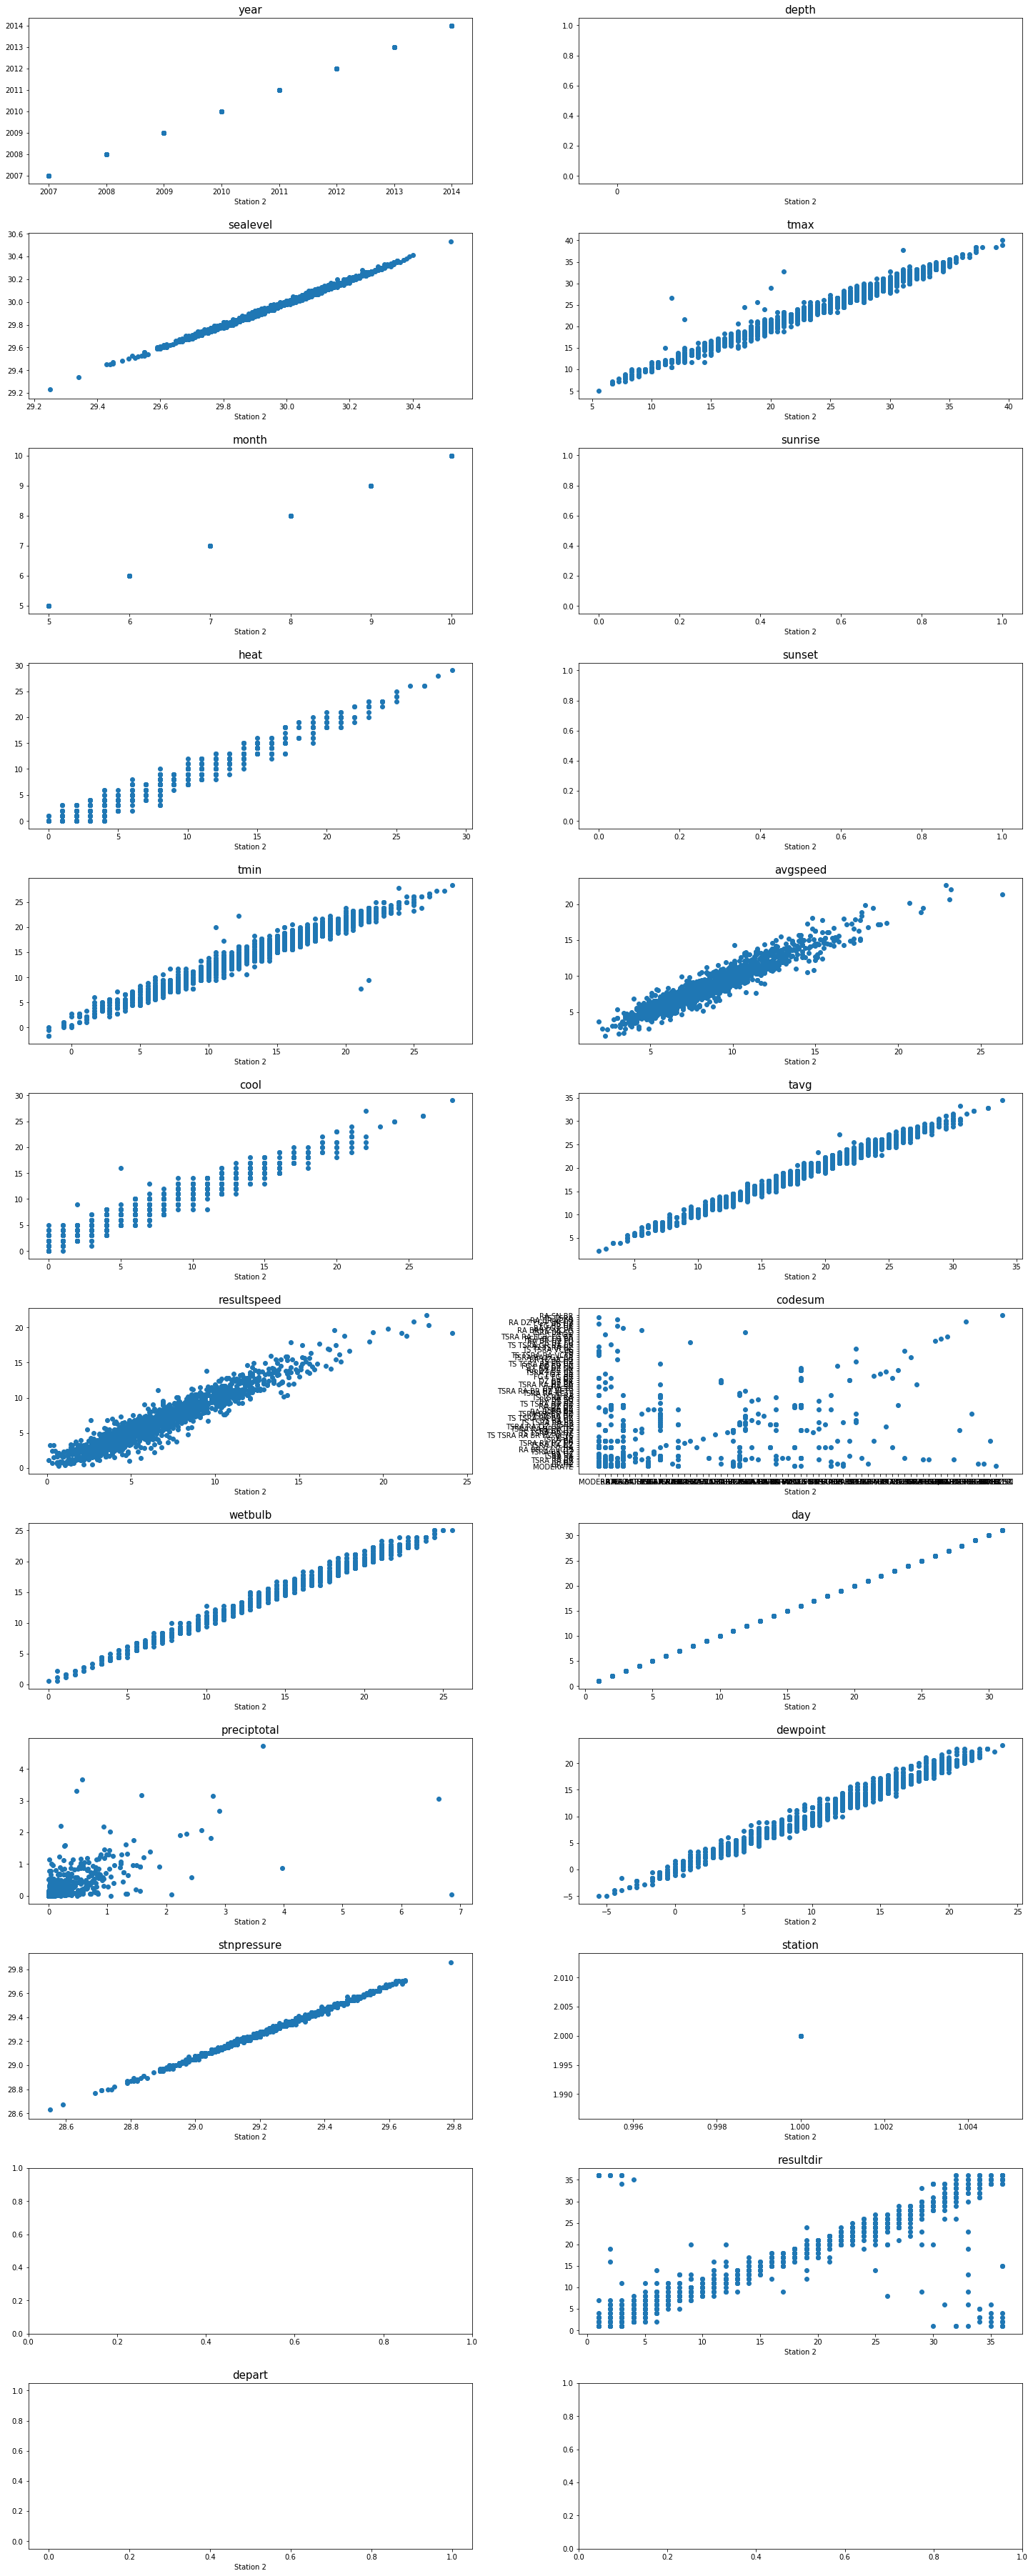

In [30]:
scatter(column_names)

As graphs above have shown, weather data from station 1 and station 2 is very similar.
But station 1 has much less missing values. The decision is to fill NA in station 1 with info from station 2 and drop station 2 columns.

In [31]:
index_st1=df_weather_st1[df_weather_st1.isnull().any(axis=1)].index
df_weather_st1[df_weather_st1.isnull().any(axis=1)]

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,day,month,year
416,1,2009-06-18,26.67,16.11,21.67,-17.22,17.22,19.44,0.0,6.0,...,0.0,0.12,29.08,NaN,6.7,16,7.9,18,6,2009
424,1,2009-06-26,30.00,20.56,25.56,-13.89,15.56,NaN,0.0,13.0,...,0.0,0.00,NaN,29.85,6.4,4,8.2,26,6,2009
497,1,2009-09-07,25.00,15.00,20.00,-17.22,15.00,16.67,0.0,3.0,...,0.0,0.00,29.39,NaN,5.8,3,4.0,7,9,2009
866,1,2011-09-08,23.89,13.89,18.89,-17.78,11.67,15.00,0.0,1.0,...,0.0,0.05,29.34,NaN,13.0,2,13.4,8,9,2011
878,1,2011-09-20,23.33,9.44,16.67,-17.78,12.22,14.44,3.0,0.0,...,0.0,0.00,29.26,NaN,7.3,18,7.3,20,9,2011
1045,1,2012-09-03,31.11,21.67,26.67,-11.11,21.11,22.78,0.0,15.0,...,0.0,0.00,29.17,NaN,4.6,6,4.4,3,9,2012
1205,1,2013-08-10,27.22,17.78,22.78,-17.78,13.89,NaN,0.0,8.0,...,0.0,0.00,NaN,30.08,5.3,5,6.5,10,8,2013
1206,1,2013-08-11,27.22,15.56,21.67,-18.89,16.11,NaN,0.0,6.0,...,0.0,0.01,29.35,30.07,2.0,27,3.0,11,8,2013


In [32]:
df_weather_st2.loc[index_st1,:]

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,day,month,year
416,2,2009-06-18,27.22,17.22,22.22,NaN,17.78,19.44,0.0,7.0,...,NaN,0.11,29.15,29.79,3.7,17,5.8,18,6,2009
424,2,2009-06-26,30.00,22.22,26.11,NaN,16.11,19.44,0.0,14.0,...,NaN,0.00,29.20,29.83,6.4,4,8.0,26,6,2009
497,2,2009-09-07,25.00,17.22,21.11,NaN,15.00,17.22,0.0,5.0,...,NaN,0.00,29.44,30.09,6.3,4,6.9,7,9,2009
866,2,2011-09-08,23.33,16.67,20.00,NaN,12.22,15.00,0.0,3.0,...,NaN,0.06,29.36,30.03,14.9,2,15.2,8,9,2011
878,2,2011-09-20,23.89,11.67,17.78,NaN,12.22,14.44,1.0,0.0,...,NaN,0.01,29.33,29.99,5.8,17,6.1,20,9,2011
1045,2,2012-09-03,30.56,22.78,26.67,NaN,20.56,22.78,0.0,15.0,...,NaN,0.00,29.23,29.87,5.0,7,5.9,3,9,2012
1205,2,2013-08-10,27.22,20.00,23.89,NaN,12.78,17.22,0.0,10.0,...,NaN,0.00,NaN,30.07,6.0,6,7.4,10,8,2013
1206,2,2013-08-11,28.89,17.22,23.33,NaN,13.89,17.78,0.0,9.0,...,NaN,0.05,29.42,30.06,4.0,24,5.4,11,8,2013


In [33]:
# Filling NA in station 1 with info from station 2
df_weather_st1.loc[:,'wetbulb'].fillna(df_weather_st2['wetbulb'],inplace=True)
df_weather_st1.loc[:,'stnpressure'].fillna(df_weather_st2['stnpressure'],inplace=True)
df_weather_st1.loc[:,'sealevel'].fillna(df_weather_st2['sealevel'],inplace=True)
# row with index 1205 don't have value in both stations. 
# It will be filled with info from the next day
df_weather_st1.loc[:,'stnpressure'].fillna(29.42,inplace=True);

C:\Users\junyu\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [34]:
df_weather_st1.isnull().sum()
# now we don't have missing values in weather df

station        0
date           0
tmax           0
tmin           0
tavg           0
depart         0
dewpoint       0
wetbulb        0
heat           0
cool           0
sunrise        0
sunset         0
codesum        0
depth          0
snowfall       0
preciptotal    0
stnpressure    0
sealevel       0
resultspeed    0
resultdir      0
avgspeed       0
day            0
month          0
year           0
dtype: int64

In [35]:
numeric_df = weather_two_stations._get_numeric_data()
wnv_matrix = np.abs(numeric_df.corr())
print(wnv_matrix['tavg_x'].sort_values(ascending=False))

tavg_x           1.000000
tavg_y           0.992287
tmax_x           0.966200
wetbulb_x        0.963575
tmax_y           0.958986
tmin_y           0.958176
wetbulb_y        0.958028
tmin_x           0.957570
dewpoint_x       0.888076
cool_y           0.883134
heat_x           0.878718
dewpoint_y       0.878407
cool_x           0.868147
heat_y           0.853785
depart_x         0.658349
sunset_x         0.582790
sunrise_x        0.500286
sealevel_y       0.277051
month_x          0.245784
month_y          0.245784
sealevel_x       0.232262
stnpressure_y    0.207837
stnpressure_x    0.198335
resultspeed_y    0.160630
resultspeed_x    0.158168
avgspeed_y       0.147216
avgspeed_x       0.140962
preciptotal_x    0.084429
preciptotal_y    0.063004
resultdir_x      0.024260
day_x            0.023280
day_y            0.023280
year_x           0.017639
year_y           0.017639
resultdir_y      0.002162
station_x             NaN
station_y             NaN
depart_y              NaN
sunrise_y   

In [36]:
corr_mat = numeric_df.corr().abs()
weather_mat = round(corr_mat.unstack(), 4)
weather_mat.sort_values(ascending = False).drop_duplicates()

year_y         year_y           1.0000
stnpressure_y  stnpressure_x    0.9982
sealevel_x     sealevel_y       0.9977
stnpressure_y  sealevel_x       0.9942
sealevel_x     stnpressure_x    0.9936
                                 ...  
resultdir_y    wetbulb_x        0.0012
depart_x       resultspeed_y    0.0005
               day_x            0.0001
month_y        day_x            0.0000
station_x      station_x           NaN
Length: 472, dtype: float64

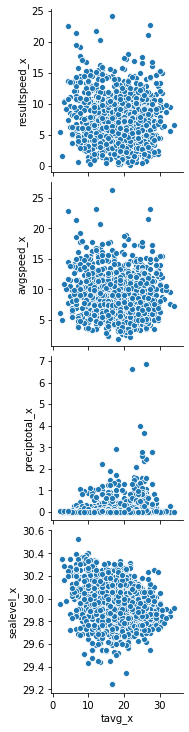

In [37]:
sns.pairplot(weather_two_stations, y_vars= ['resultspeed_x', 'avgspeed_x', 'preciptotal_x', 'sealevel_x'],
             x_vars=['tavg_x']);

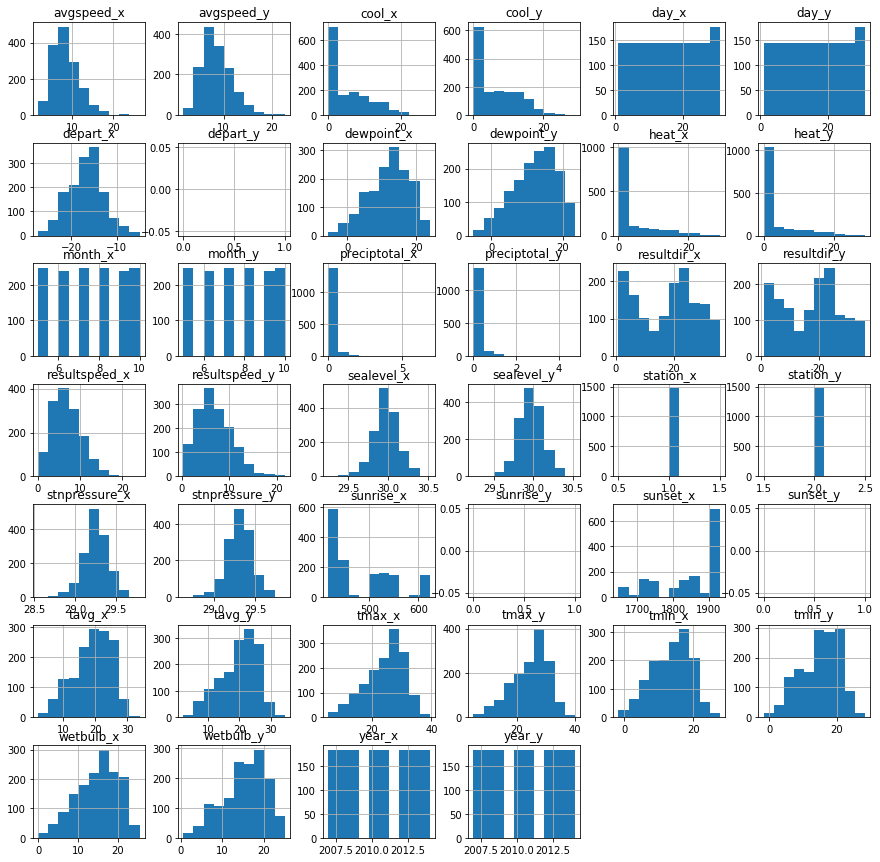

In [38]:
numeric_df.hist(figsize=(15,15));

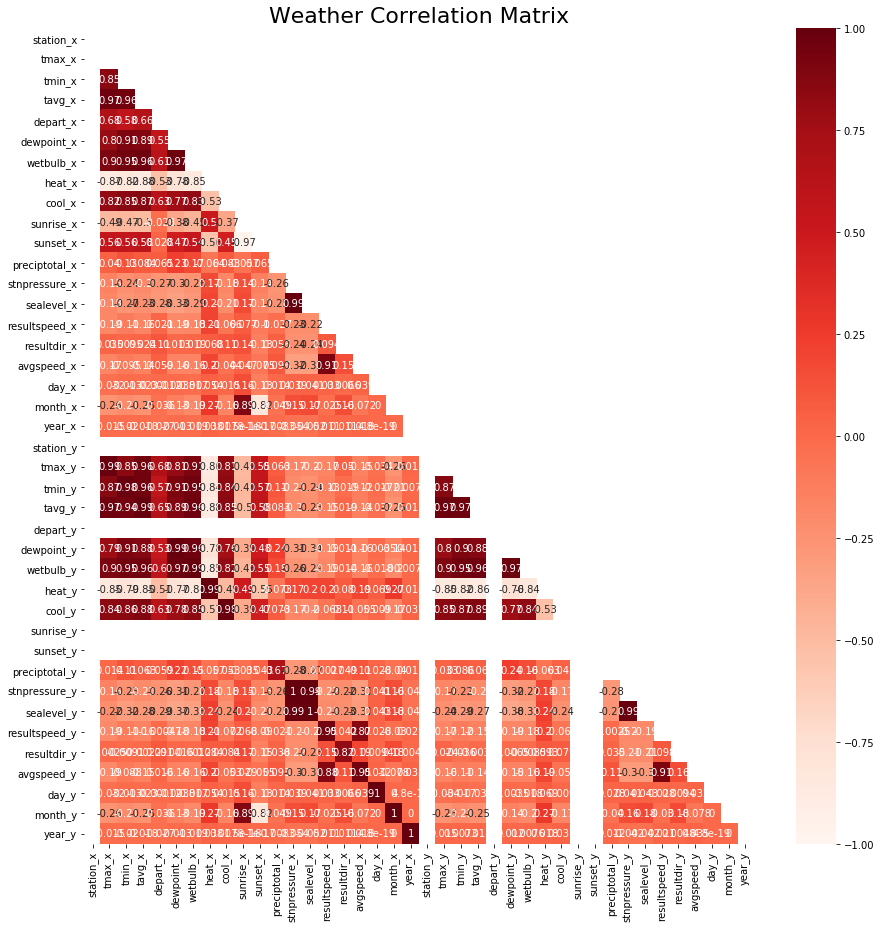

In [39]:
# Setting up the size of the figure
plt.figure(figsize=(15,15))
# Insert the title 
plt.title("Weather Correlation Matrix", fontsize=22) 
corr = numeric_df.corr()
# Set up mask to be True to hide upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
heat_map = sns.heatmap(corr,mask=mask,annot=True,vmin=-1,vmax=1,cmap="Reds")

### EDA - Spray dataset

In [40]:
# Choosing columns for clustering
X = df_spray[['day', 'month','year','latitude', 'longitude']]

In [41]:
# Standartizing data
ss = StandardScaler()
X_scaled = ss.fit_transform(X)
# Training DBSCAN for predicting 
dbs = DBSCAN(eps=0.1)
dbs.fit(X)

DBSCAN(algorithm='auto', eps=0.1, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [42]:
# Verifying labels (there should be 13)
np.unique(dbs.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [43]:
# Adding labels to spray df
df_spray['labels'] = dbs.labels_

In [44]:
df_spray.head()

,date,latitude,longitude,day,month,year,labels
0,2011-08-29,42.391623,-88.089163,29,8,2011,0
1,2011-08-29,42.391348,-88.089163,29,8,2011,0
2,2011-08-29,42.391022,-88.089157,29,8,2011,0
3,2011-08-29,42.390637,-88.089158,29,8,2011,0
4,2011-08-29,42.390410,-88.088858,29,8,2011,0


In [45]:
df_spray = df_spray.loc[df_spray['longitude'] > -88]

In [46]:
# Looking at result
clusteres_df = df_spray.groupby(['labels','date']).count()
clusteres_df.sort_values('date')

,,latitude,longitude,day,month,year
labels,date,,,,,
1,2011-09-07,2114,2114,2114,2114,2114
2,2013-07-17,556,556,556,556,556
3,2013-07-17,1646,1646,1646,1646,1646
4,2013-07-25,1607,1607,1607,1607,1607
5,2013-08-08,1195,1195,1195,1195,1195
6,2013-08-15,2668,2668,2668,2668,2668
7,2013-08-16,141,141,141,141,141
8,2013-08-22,845,845,845,845,845
9,2013-08-22,742,742,742,742,742


In [47]:
# Defining min and max latitudes and longitudes for each cluster
min_spray = max_spray = df_spray.groupby('labels')[['date','latitude','longitude']].min()
max_spray = max_spray = df_spray.groupby('labels')[['latitude','longitude']].max()

In [48]:
# Merging min and max df in one
min_max_spray = pd.merge(min_spray,max_spray,on='labels')
# Renaming columns to make them more understandable
min_max_spray.columns = ['date', 'latitude_min', 'longitude_min', 'latitude_max', 'longitude_max'] 

In [49]:
min_max_spray

,date,latitude_min,longitude_min,latitude_max,longitude_max
labels,,,,,
1,2011-09-07,41.968435,-87.836560,41.997028,-87.787710
2,2013-07-17,41.972617,-87.871023,42.015098,-87.762165
3,2013-07-17,41.714098,-87.672362,41.743287,-87.629355
4,2013-07-25,41.939308,-87.739840,41.968097,-87.707987
5,2013-08-08,41.917227,-87.716847,41.946703,-87.678060
6,2013-08-15,41.887825,-87.818408,41.966532,-87.745625
7,2013-08-16,41.911375,-87.785792,41.964712,-87.746675
8,2013-08-22,41.873487,-87.730655,41.895475,-87.701623
9,2013-08-22,41.713925,-87.623142,41.765277,-87.586727


### EDA - Train dataset

In [50]:
df_train.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,day,month,year
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,29,5,2007
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,29,5,2007
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,29,5,2007
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,29,5,2007
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,29,5,2007


### Bryan Pushing his EDA Here /Start

In [51]:
# Codes
# Create temproray dataframe by merging cleaned df_train and df_weather dataframes
df = pd.merge(df_train, df_weather, on="date")

# Select a few columns for analysis
df = df[['date', 'nummosquitos', 'species', 'tavg', 'wnvpresent', 'sealevel', 'dewpoint', 'wetbulb', 'preciptotal', 'stnpressure']]

# Create another temporary variable, this is the mean temperature, mosquitos and wnv present
df_mean = df.groupby(['date']).mean()

# Segregate species that carry WNV or not
df['wnvspecies'] = [1 if ('PIPIENS' or 'RESTUANS') in row else 0 for row in df['species']]

# Segregate Non-Pipiens / Restuans (0), Pip&Rest w/o WNV (1), Pip&Rest with WNV (0)
df['3cat'] = df['wnvspecies'] + df['wnvpresent']

# Create 2 temporary dataframes to categorise data by month (average for weather, total for mosquito and virus data)
df_date = df.groupby('date')['nummosquitos','wnvpresent'].sum()
df_temp = df.groupby('date')['tavg','wetbulb'].mean()
df_date['tavg'] = df_temp['tavg']
df_date['wetbulb'] = df_temp['wetbulb']

df_date_month = df_date.groupby(by=[df_date.index.month])['nummosquitos','wnvpresent'].sum()
df_temp_month = df_date.groupby(by=[df_date.index.month])['tavg','wetbulb'].mean()
df_date_month['tavg'] = df_temp_month['tavg']
df_date_month['wetbulb'] = df_temp_month['wetbulb']

C:\Users\junyu\anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
C:\Users\junyu\anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
C:\Users\junyu\anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
C:\Users\junyu\anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


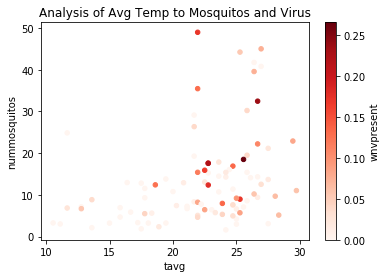

In [52]:
# Higher Temperature = More Mosquitos = Higher weightage of WNV Present

fig, ax = plt.subplots()
df_mean.plot.scatter(x='tavg', y='nummosquitos', c='wnvpresent', colormap='Reds', ax=ax)
ax.set_title('Analysis of Avg Temp to Mosquitos and Virus');

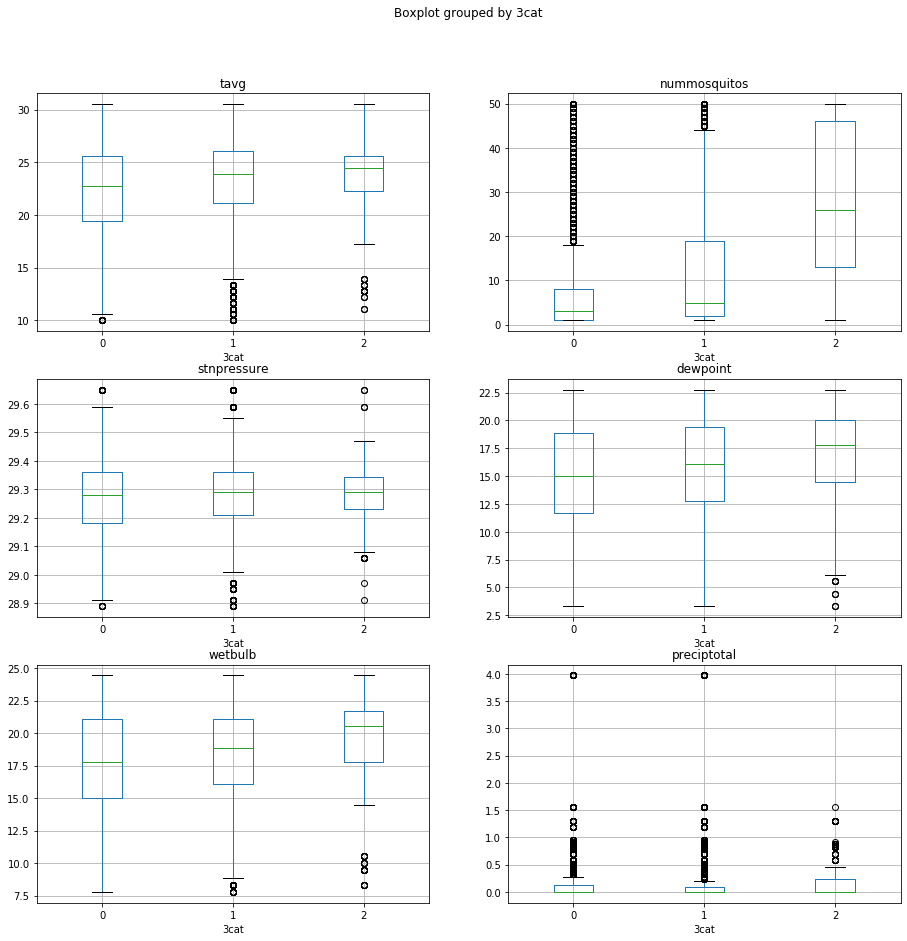

In [53]:
# Category labels:
# 0 [Non-Pipiens & Restuans (Statistically 0 WNV Present)]
# 1 [Pipiens & Restuans with NO WNV]
# 2 [Pipiens & Restuans WITH WNV]

fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(15,15)) 

df.boxplot(column='tavg', by='3cat', ax=axes[0,0]) 
df.boxplot(column='nummosquitos', by='3cat', ax=axes[0,1]) 
df.boxplot(column='stnpressure', by='3cat', ax=axes[1,0]) 
df.boxplot(column='dewpoint', by='3cat', ax=axes[1,1]) 
df.boxplot(column='wetbulb', by='3cat', ax=axes[2,0]) 
df.boxplot(column='preciptotal', by='3cat', ax=axes[2,1]) 

plt.show()

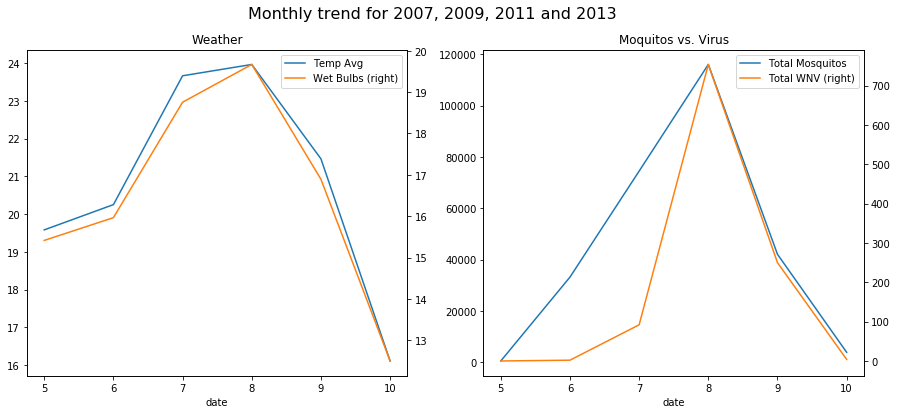

In [54]:
# Month by month analysis for training dataset

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,6))

fig.suptitle("Monthly trend for 2007, 2009, 2011 and 2013", fontsize=16)
df_date_month.tavg.plot(label="Temp Avg", legend=True, ax=axes[0])
df_date_month.wetbulb.plot(secondary_y=True, label="Wet Bulbs", legend=True, ax=axes[0])
axes[0].set_title('Weather')

df_date_month.nummosquitos.plot(label='Total Mosquitos', legend=True,  ax=axes[1]) 
df_date_month.wnvpresent.plot(label='Total WNV', legend=True, ax=axes[1], secondary_y=True)
axes[1].set_title('Moquitos vs. Virus')

plt.show()

### Bryan Pushing his EDA Here /End

#### Merge df_train by date, followed by by trap

In [55]:
df_train_groupbydate_trap = df_train.groupby(['date','trap'])

In [56]:
def chkWNV(series):
    return 1 if series.sum() > 0 else 0

In [57]:
# Merge by Date, followed by Trap
df_train_bydate_trap = pd.DataFrame(columns=['date', 'address', 'species',
                                             'block', 'street', 'trap',
                                             'addressnumberandstreet',
                                             'latitude', 'longitude',
                                             'addressaccuracy',
                                             'nummosquitos', 'wnvpresent'])

for date_trap, df in df_train_groupbydate_trap:
    df_train_bydate_trap.loc[len(df_train_bydate_trap)] = [date_trap[0],
                                                           np.unique(df['address'])[0],
                                                           np.unique(df['species']),
                                                           np.unique(df['block'])[0],
                                                           np.unique(df['street'])[0],
                                                           date_trap[1], 
                                                           np.unique(df['addressnumberandstreet'])[0], 
                                                           np.unique(df['latitude'])[0],
                                                           np.unique(df['longitude'])[0],
                                                           np.unique(df['addressaccuracy'])[0],
                                                           sum(df['nummosquitos']),
                                                           chkWNV(df['wnvpresent'])]

In [58]:
df_train_bydate_trap.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...","[CULEX PIPIENS/RESTUANS, CULEX RESTUANS]",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,2,0
1,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",[CULEX RESTUANS],62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
2,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA","[CULEX PIPIENS/RESTUANS, CULEX RESTUANS]",79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,5,0
3,2007-05-29,"1500 West Webster Avenue, Chicago, IL 60614, USA",[CULEX RESTUANS],15,W WEBSTER AVE,T045,"1500 W WEBSTER AVE, Chicago, IL",41.921600,-87.666455,8,2,0
4,2007-05-29,"2500 West Grand Avenue, Chicago, IL 60654, USA",[CULEX RESTUANS],25,W GRAND AVE,T046,"2500 W GRAND AVE, Chicago, IL",41.891118,-87.654491,8,1,0


In [59]:
df_train_bydate_trap['species'] = df_train_bydate_trap['species'].apply(','.join)

In [60]:
df_train_bydate_trap['iswnvspecies'] = df_train_bydate_trap['species'].str.contains('PIPIENS|RESTUANS').astype(int)

In [61]:
df_train_bydate_trap.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,iswnvspecies
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...","CULEX PIPIENS/RESTUANS,CULEX RESTUANS",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,2,0,1
1,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,1
2,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA","CULEX PIPIENS/RESTUANS,CULEX RESTUANS",79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,5,0,1
3,2007-05-29,"1500 West Webster Avenue, Chicago, IL 60614, USA",CULEX RESTUANS,15,W WEBSTER AVE,T045,"1500 W WEBSTER AVE, Chicago, IL",41.921600,-87.666455,8,2,0,1
4,2007-05-29,"2500 West Grand Avenue, Chicago, IL 60654, USA",CULEX RESTUANS,25,W GRAND AVE,T046,"2500 W GRAND AVE, Chicago, IL",41.891118,-87.654491,8,1,0,1


---

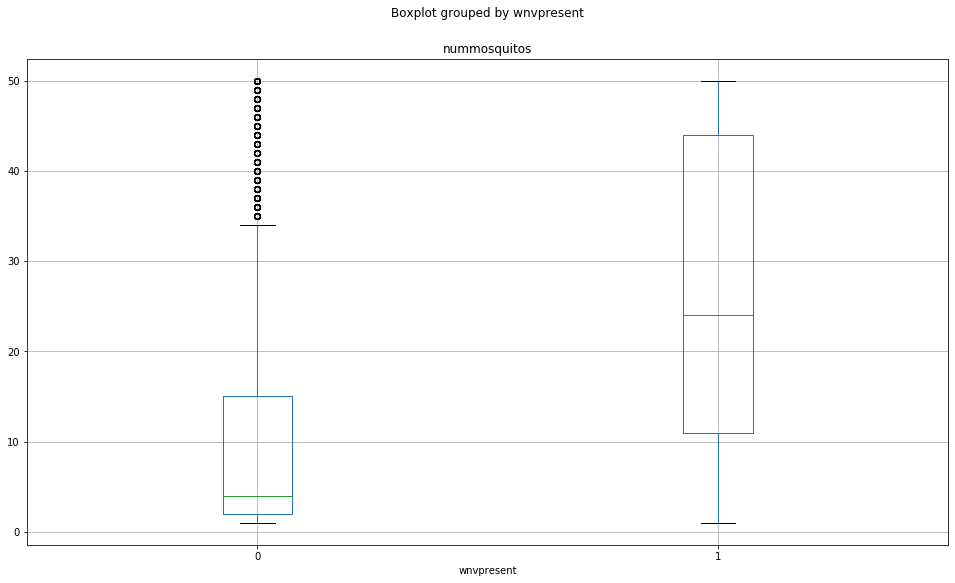

In [62]:
# Number of caught mosquitos by presence of virus
df_train.boxplot(by='wnvpresent',column='nummosquitos',figsize=(16,9));
# Virus is present if number of mosquitos is high

# These test results are organized in such a way that when the number of mosquitos exceed 50, 
# they are split into another record (another row in the dataset), 
# such that the number of mosquitos are capped at 50.

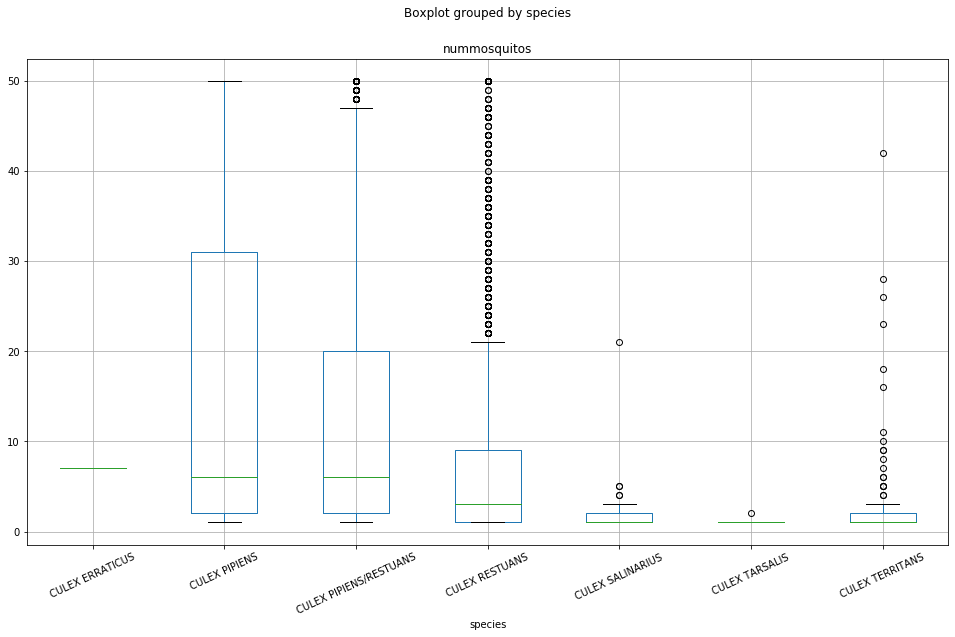

In [63]:
# Number of mosquitos by species of mosquitos
df_train.boxplot(by='species',column='nummosquitos',rot=25, figsize=(16,9));
# 2 species of mosquitos caught much frequently than others - Culex Pipiens and Culex Restuans

# Records exist only when a particular species of mosquitos is found at a certain trap 
# at a certain time. Date: date that the WNV test is performed

In [64]:
# NumMosquitos and WnvPresent by species
df_train.groupby('species')[['nummosquitos','wnvpresent']].sum()
# 2 species cought much frequantly and they contain virus - Also, Culex Pipiens and Culex Restuans
# ? does other species are rare in the area
# ? does it mean that other species can have the virus but due to their rareness we don't see it

,nummosquitos,wnvpresent
species,,
CULEX ERRATICUS,7,0
CULEX PIPIENS,44671,240
CULEX PIPIENS/RESTUANS,66268,262
CULEX RESTUANS,23431,49
CULEX SALINARIUS,145,0
CULEX TARSALIS,7,0
CULEX TERRITANS,510,0


In [65]:
df_train['trap'].value_counts()

T900     750
T115     542
T138     314
T002     185
T135     183
        ... 
T238       7
T094B      5
T076       5
T237       3
T040       2
Name: trap, Length: 136, dtype: int64

In [66]:
df_train['species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: species, dtype: int64

In [67]:
pd.pivot_table(df_train, index='species', values='wnvpresent')

,wnvpresent
species,
CULEX ERRATICUS,0.000000
CULEX PIPIENS,0.088922
CULEX PIPIENS/RESTUANS,0.055135
CULEX RESTUANS,0.017883
CULEX SALINARIUS,0.000000
CULEX TARSALIS,0.000000
CULEX TERRITANS,0.000000


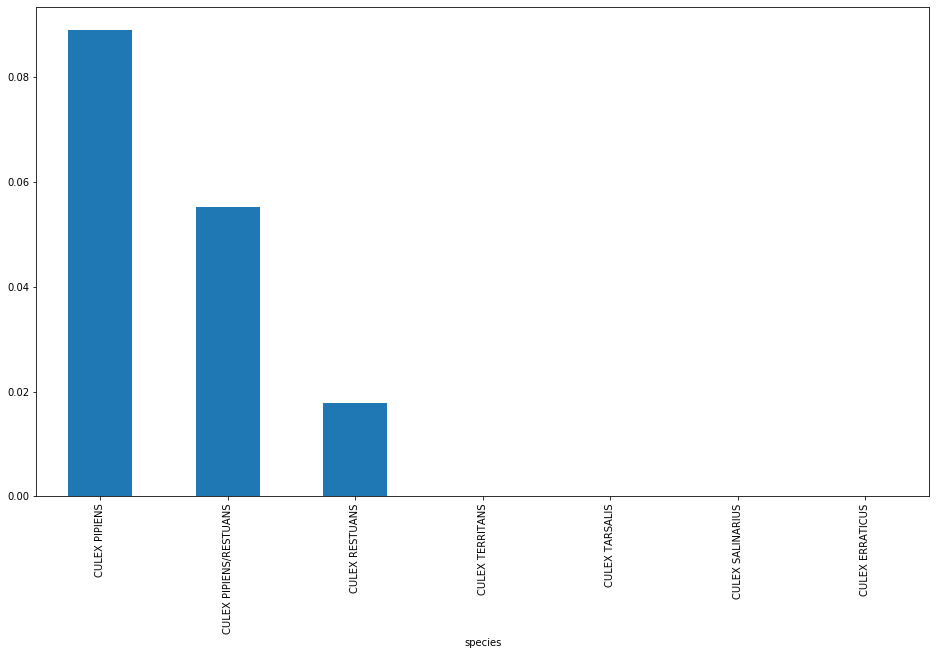

In [68]:
df_train.groupby('species')['wnvpresent'].mean().sort_values(ascending=False).plot.bar(figsize=(16,9));

In [69]:
# Get top 10 traps with highest occurance of West Nile Virus
top10 = df_train.groupby('trap')['wnvpresent','nummosquitos'].mean().sort_values(by='wnvpresent',ascending=False)
top10.head(10)

C:\Users\junyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,wnvpresent,nummosquitos
trap,,
T143,0.193548,7.419355
T006,0.166667,4.458333
T005,0.142857,3.571429
T233,0.140000,15.160000
T014,0.133333,12.133333
T096,0.120000,11.560000
T003,0.114754,11.032787
T015,0.114286,4.828571
T235,0.112903,8.983871


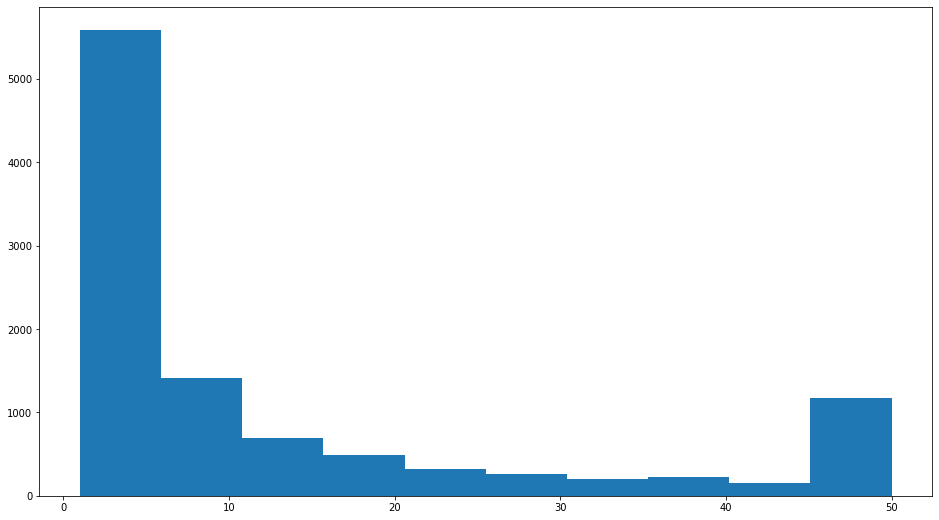

In [70]:
plt.figure(figsize=(16,9))
plt.hist(data=df_train,x='nummosquitos');

### EDA - Combined dataset

In [71]:
# Creating a new column is_spray and setting all cells as False
df_train['is_spray'] = False

In [72]:
# Setting time delta as 30 days. The spray lasts
# A typical mosquito treatment lasts about 30 days. 
# https://www.callnorthwest.com/2019/05/how-long-does-a-mosquito-treatment-last/
tdelta_min = dt.timedelta(days=0)
tdelta_max = dt.timedelta(days=30)
# Creating a new DataFrame
is_spray_df = pd.DataFrame(columns=df_train.columns)
# Looping through df with min,max latitudes and longitudes 
for i,spray in min_max_spray.iterrows():
    long_min = spray['longitude_min']
    long_max = spray['longitude_max']
    lat_min = spray['latitude_min']
    lat_max = spray['latitude_max']
# Looping through train df, checking is latitudes and longitudes lay between min and max
# and date is the same date or date +30 days of spraying 
    for j,row in df_train.iterrows():
        if ((lat_min <= row['latitude'] <= lat_max) &
            (long_min <= row['longitude'] <= long_max) &
            (tdelta_min < (row['date']-spray['date']) <=tdelta_max)):
            row['is_spray'] = True
            is_spray_df = is_spray_df.append(row)

In [73]:
# Joining new df with spray info with train data
df_train_spray = pd.concat([df_train,is_spray_df])

In [74]:
# Checking number of rows in train which were sprayed
df_train_spray['is_spray'].value_counts()

False    10506
True       247
Name: is_spray, dtype: int64

In [75]:
# Merging weather and train df
main_df = pd.merge(df_train_spray,df_weather_st1,on=['date','day','month','year'])
main_df.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,...,sunset,codesum,depth,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,1917.0,BR HZ,0,0.0,0.0,29.39,30.11,5.8,18,6.5
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,1917.0,BR HZ,0,0.0,0.0,29.39,30.11,5.8,18,6.5
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,1917.0,BR HZ,0,0.0,0.0,29.39,30.11,5.8,18,6.5
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,1917.0,BR HZ,0,0.0,0.0,29.39,30.11,5.8,18,6.5
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,1917.0,BR HZ,0,0.0,0.0,29.39,30.11,5.8,18,6.5


In [76]:
main_df.columns

Index(['date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'nummosquitos', 'wnvpresent', 'day', 'month', 'year', 'is_spray',
       'station', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb',
       'heat', 'cool', 'sunrise', 'sunset', 'codesum', 'depth', 'snowfall',
       'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir',
       'avgspeed'],
      dtype='object')

In [77]:
main_df['nummosquitos'] = main_df.loc[:,'nummosquitos'].astype('int')
main_df['wnvpresent'] = main_df['wnvpresent'].astype('int')

In [78]:
main_df['is_spray'] = main_df['is_spray'].map({True:1,False:0})

In [79]:
main_df['wnvpresent'].value_counts(normalize=True)

0    0.945876
1    0.054124
Name: wnvpresent, dtype: float64

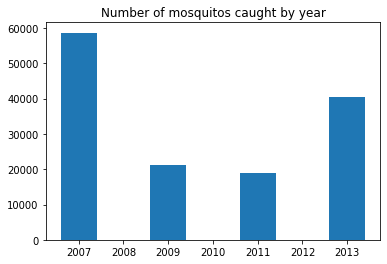

In [80]:
year_numb = main_df.groupby('year')['nummosquitos'].sum()
plt.bar(year_numb.index,year_numb.values)
plt.title('Number of mosquitos caught by year');

## Feature Engineering

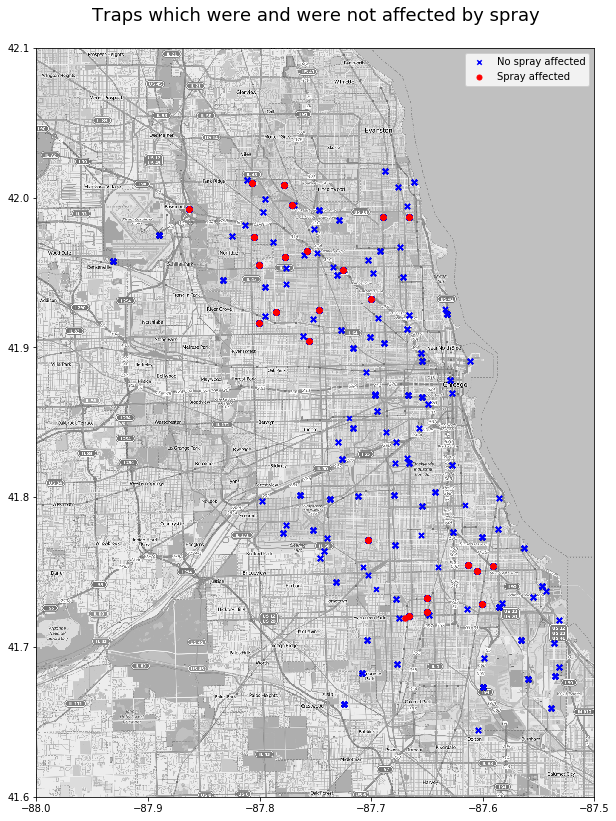

In [81]:
spray_traps = main_df[main_df['is_spray']==True]
spray_no_traps = main_df[main_df['is_spray']==False]

lats_spray = spray_traps['latitude']
longs_spray = spray_traps['longitude']
lats_no_spray = spray_no_traps['latitude']
longs_no_spray = spray_no_traps['longitude']

f.gen_map()

plt.scatter(x=longs_no_spray, y=lats_no_spray, c='b', s=20, marker='x',label='No spray affected')
plt.scatter(x=longs_spray, y=lats_spray, c='r', s=25,label='Spray affected')
plt.title('Traps which were and were not affected by spray\n',fontsize=18)
plt.legend()
plt.show();

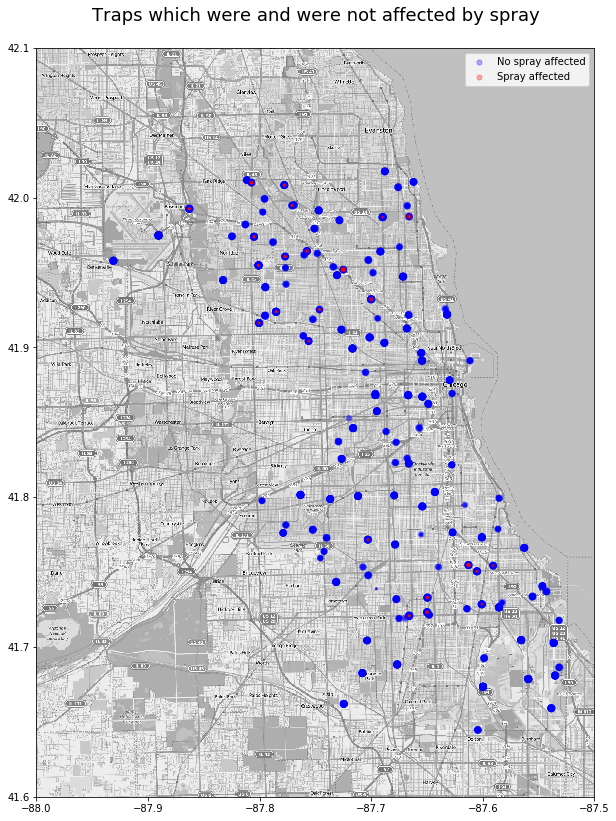

In [82]:
spray_traps = main_df[main_df['is_spray']==True]
spray_no_traps = main_df[main_df['is_spray']==False]

lats_spray = spray_traps['latitude']
longs_spray = spray_traps['longitude']
lats_no_spray = spray_no_traps['latitude']
longs_no_spray = spray_no_traps['longitude']
size_num_mosq_spray = spray_traps['nummosquitos']
size_num_mosq_no_spray = spray_no_traps['nummosquitos']
# generate plot
f.gen_map()

plt.scatter(x=longs_no_spray, y=lats_no_spray, c='b', s=size_num_mosq_spray, label='No spray affected',alpha=0.3)
plt.scatter(x=longs_spray, y=lats_spray, c='r', s=size_num_mosq_no_spray,label='Spray affected',alpha=0.3)
plt.title('Traps which were and were not affected by spray\n',fontsize=18)
plt.legend()
plt.show()

In [83]:
spray_traps = main_df[main_df['is_spray']==True]
spray_no_traps = main_df[main_df['is_spray']==False]

In [84]:
# Number of mosq caught with spray applied
spray_traps[['wnvpresent','nummosquitos']].describe().T

,count,mean,std,min,25%,50%,75%,max
wnvpresent,247.0,0.125506,0.331965,0.0,0.0,0.0,0.0,1.0
nummosquitos,247.0,16.105263,14.829007,1.0,4.0,10.0,26.5,50.0


In [85]:
# Number of mosq caught without spray applied
spray_no_traps[['wnvpresent','nummosquitos']].describe().T
# We see that number of mosquitos large whrn spray was applied, the resion can be 
# the seasonal spraying - only those days when number of mosquitos is high
# let's investigate it

,count,mean,std,min,25%,50%,75%,max
wnvpresent,10506.0,0.052446,0.222936,0.0,0.0,0.0,0.0,1.0
nummosquitos,10506.0,12.853512,16.133816,1.0,2.0,5.0,17.0,50.0


In [86]:
# Let's compare number of mosq in places where spray was present 
# and was not present in the same dates.

# For this no spray df should be filtered by days
# getting unique dates of spray
days = np.unique(spray_traps['date'].values)
# creating a new df
spray_other_location = pd.DataFrame()
# iter though days and no spray df
for day in days:
    for i,row in spray_no_traps.iterrows():
#         checking if date is the same
        if row['date'] == day:
#         if True - adding to new df
            spray_other_location = spray_other_location.append(row)

In [87]:
# cheking new df
spray_other_location.head(2)

,address,addressaccuracy,addressnumberandstreet,avgspeed,block,codesum,cool,date,day,depart,...,street,sunrise,sunset,tavg,tmax,tmin,trap,wetbulb,wnvpresent,year
7686,"4100 North Oak Park Avenue, Chicago, IL 60634,...",9.0,"4100 N OAK PARK AVE, Chicago, IL",10.9,41.0,MODERATE,10.0,2011-09-12,12.0,-12.22,...,N OAK PARK AVE,528.0,1809.0,23.89,30.0,17.78,T002,18.33,0.0,2011.0
7687,"4100 North Oak Park Avenue, Chicago, IL 60634,...",9.0,"4100 N OAK PARK AVE, Chicago, IL",10.9,41.0,MODERATE,10.0,2011-09-12,12.0,-12.22,...,N OAK PARK AVE,528.0,1809.0,23.89,30.0,17.78,T002,18.33,0.0,2011.0


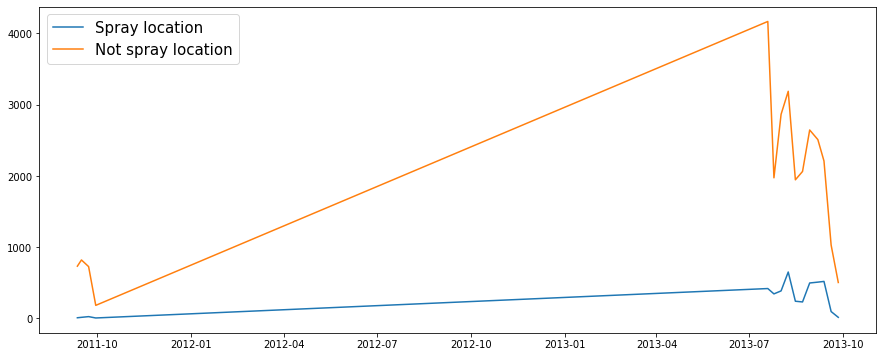

In [88]:
# let's compare num_mosquitoes in dates when spray were applied in spray and no spray locations
plt.figure(figsize=(15,6))
date_n_mosq_spr = spray_traps.groupby(['date'])['nummosquitos'].sum()
date_n_mosq_no_spr = spray_other_location.groupby(['date'])['nummosquitos'].sum()
plt.plot(date_n_mosq_spr.index,date_n_mosq_spr.values,label='Spray location')
plt.plot(date_n_mosq_no_spr.index,date_n_mosq_no_spr.values,label='Not spray location')
plt.legend(prop={'size': 15});

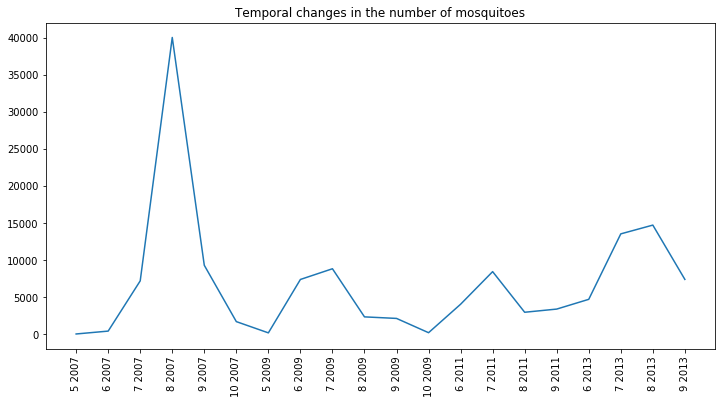

In [89]:
# Visualisation of temporal trend of number of mosquitoes 
main_df['month'] = main_df['date'].map(lambda x: x.month)
num_mosq_month = main_df.groupby(['year','month'])['nummosquitos'].sum().reset_index(level=[0,1])
plt.figure(figsize=(12,6))
plt.plot(num_mosq_month['nummosquitos'])
plt.xticks(range(len(num_mosq_month)),
labels=list(num_mosq_month['month'].astype('str')+' '+num_mosq_month['year'].astype('str')),
          rotation='vertical')
plt.title('Temporal changes in the number of mosquitoes');

From the linegraph it can be seen that the train dataset contain information only about 5th,6th,7th,8th,9th and 10th months of 2007,2009,2011 and 2013 years.

The biggest numbers of mosquitoes are in 7th and 8th each year.

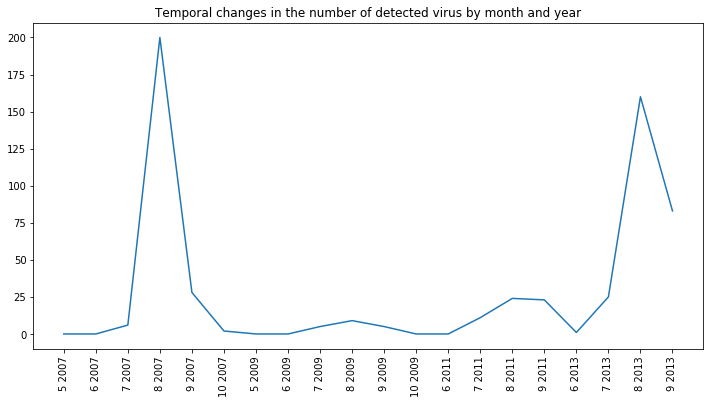

In [90]:
num_mosq_month = main_df.groupby(['year','month'])['wnvpresent'].sum().reset_index(level=[0,1])
plt.figure(figsize=(12,6))
plt.plot(num_mosq_month['wnvpresent'])
plt.xticks(range(len(num_mosq_month)),
labels=list(num_mosq_month['month'].astype('str')+' '+num_mosq_month['year'].astype('str')),
          rotation='vertical')
plt.title('Temporal changes in the number of detected virus by month and year');

The linegraph illustrate that high number of virus was datacted in month 8.

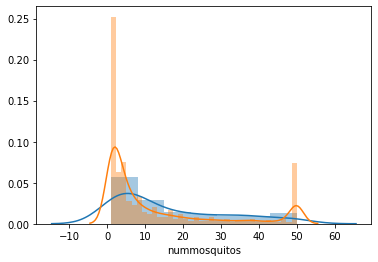

In [91]:
# distribution number of mosquitos with\without spray applied
sns.distplot(spray_traps['nummosquitos'])
sns.distplot(spray_no_traps['nummosquitos'])

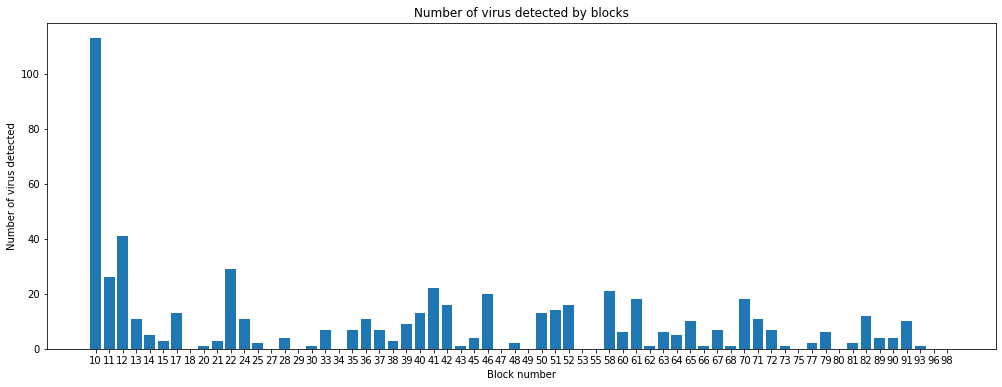

In [92]:
plt.figure(figsize=(17,6))
plt.bar(range(len(main_df['block'].unique())), main_df.groupby('block')['wnvpresent'].sum())
plt.xlabel('Block number')
plt.ylabel('Number of virus detected')
plt.title('Number of virus detected by blocks')
plt.xticks(range(len(main_df['block'].unique())),labels=sorted(main_df['block'].unique()));

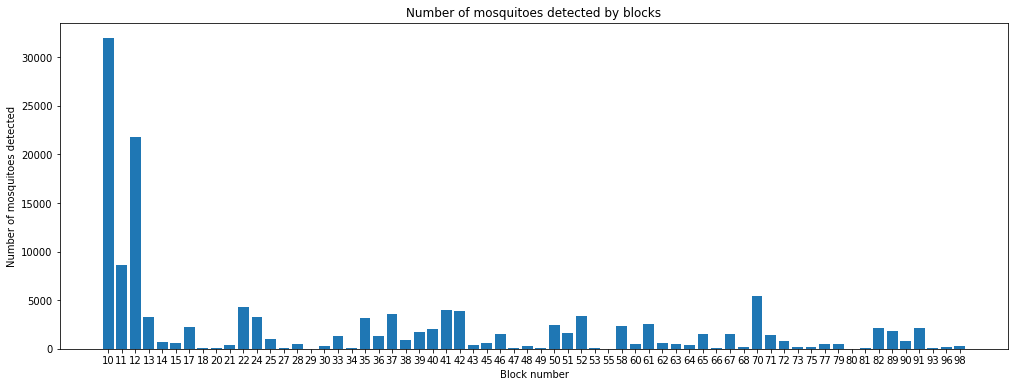

In [93]:
plt.figure(figsize=(17,6))
plt.bar(range(len(main_df['block'].unique())), main_df.groupby('block')['nummosquitos'].sum())
plt.xlabel('Block number')
plt.ylabel('Number of mosquitoes detected')
plt.title('Number of mosquitoes detected by blocks')
plt.xticks(range(len(main_df['block'].unique())),labels=sorted(main_df['block'].unique()));

It can be seen that 10th block have the anomaly high number of virus detected and number of mosquitoes.

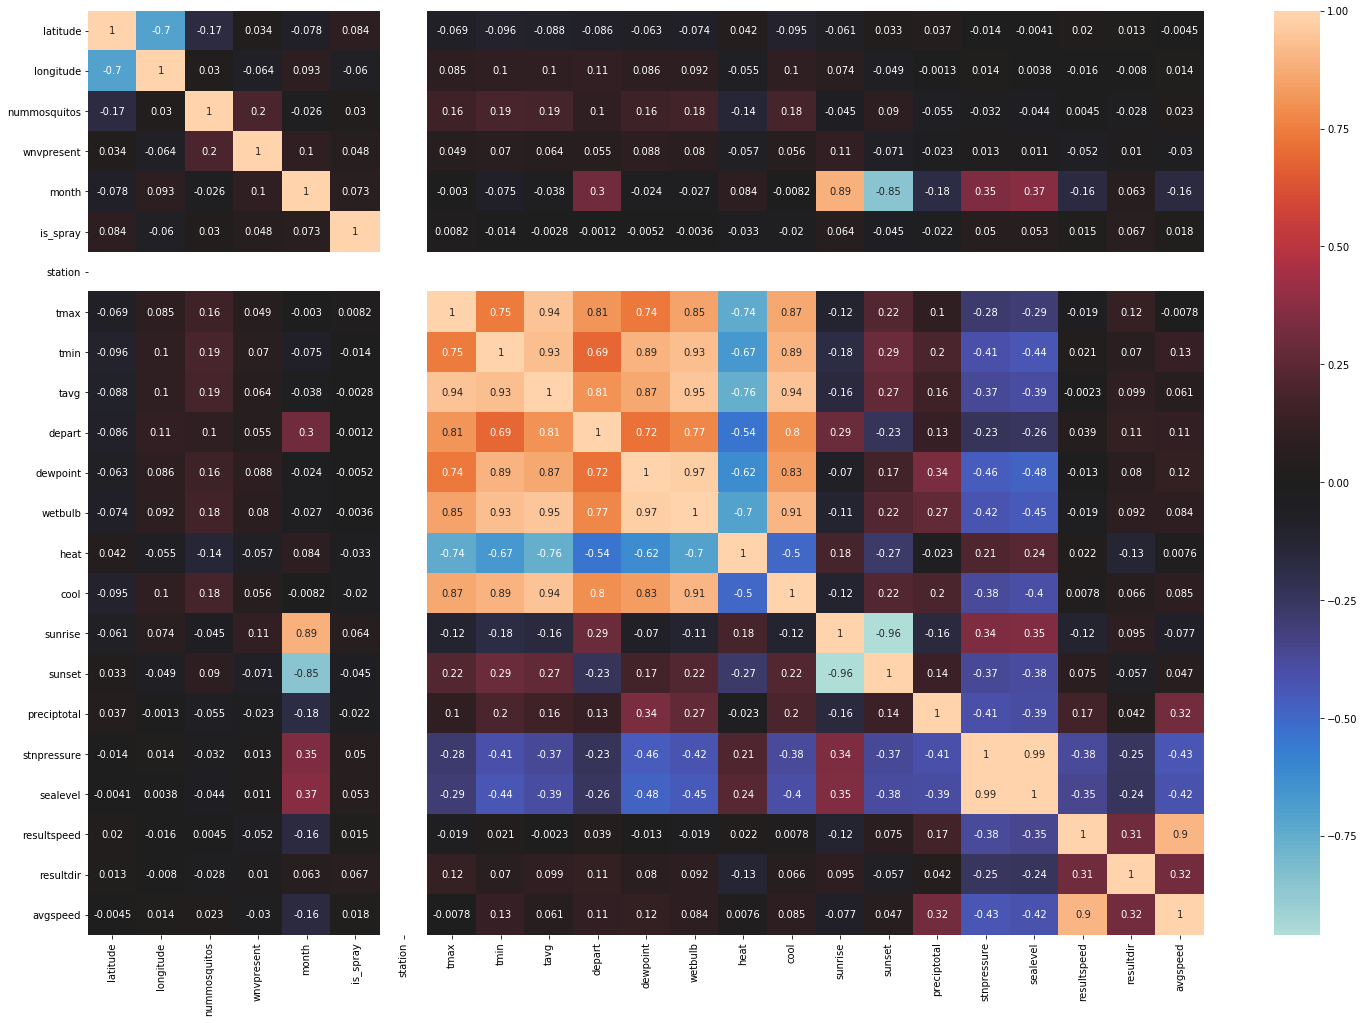

In [94]:
plt.figure(figsize=(25,17))
sns.heatmap(main_df.corr(),annot=True,center=0);

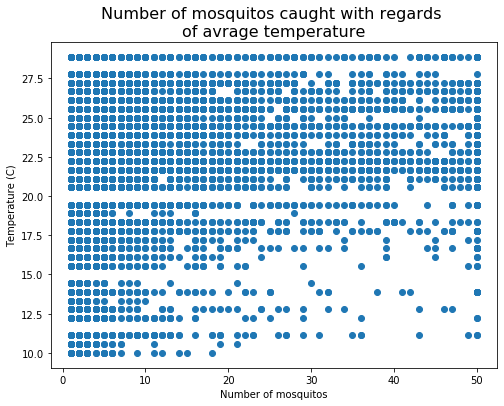

In [95]:
fig=plt.figure(figsize=(8,6))
plt.scatter(main_df['nummosquitos'],main_df['tavg'])
plt.title('Number of mosquitos caught with regards \nof avrage temperature',fontsize=16)
plt.xlabel('Number of mosquitos')
plt.ylabel('Temperature (C)');

In [96]:
# Now let's compare number of mosq there spray and no spray with same dates
# Number of mosq caught with spray applied
grouped_spray = spray_traps.groupby(['date','trap'])[['wnvpresent','nummosquitos']].sum()
grouped_spray[['wnvpresent','nummosquitos']].describe().T

,count,mean,std,min,25%,50%,75%,max
wnvpresent,109.0,0.284404,0.578820,0.0,0.0,0.0,0.0,2.0
nummosquitos,109.0,36.495413,45.879799,1.0,9.0,20.0,44.0,248.0


In [97]:
# Number of mosq caught with spray not applied
grouped_no_spray = spray_other_location.groupby(['date','trap'])[['wnvpresent','nummosquitos']].sum()
grouped_no_spray[['wnvpresent','nummosquitos']].describe().T

,count,mean,std,min,25%,50%,75%,max
wnvpresent,1003.0,0.245264,0.755330,0.0,0.0,0.0,0.0,12.0
nummosquitos,1003.0,27.488534,58.491385,1.0,4.0,11.0,29.5,984.0


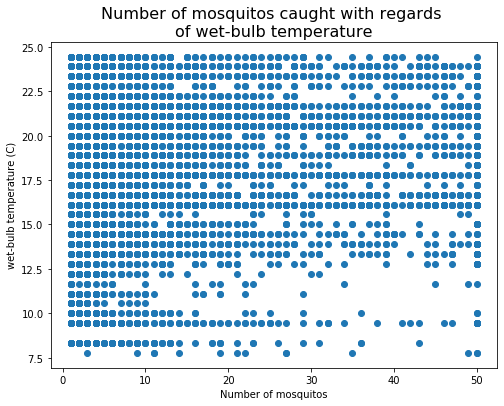

In [98]:
# Plotting distribution the number of mosquitoes with regards to wet bulb from station 1
fig=plt.figure(figsize=(8,6))
plt.scatter(main_df['nummosquitos'],main_df['wetbulb'])
plt.title('Number of mosquitos caught with regards \nof wet-bulb temperature',fontsize=16)
plt.xlabel('Number of mosquitos')
plt.ylabel('wet-bulb temperature (C)');

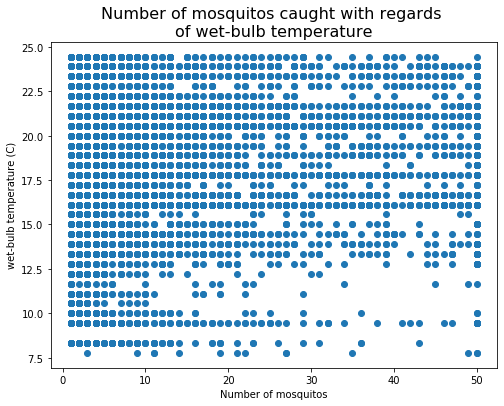

In [99]:
# Plotting the same graph but taken information of wet bulb from station 2
fig=plt.figure(figsize=(8,6))
plt.scatter(main_df['nummosquitos'],main_df['wetbulb'])
plt.title('Number of mosquitos caught with regards \nof wet-bulb temperature',fontsize=16)
plt.xlabel('Number of mosquitos')
plt.ylabel('wet-bulb temperature (C)');
# The scatterplots showen that the information from station 1 is incomplete,
# let's explore the information from station 1 and station 2

As two bunch of graphs above have shown, weather data from station 1 and station 2 is very similar.

The scatterplots showed that despite linear relationships between the weather information, there are some outliers or anomalies. 
The boxplots illustrated that those anomalies and outliers were recorded on station 1. The decision is to fill all NA of station 2 with info from station 1 and drow all columns from station 1.